In [56]:
from pathlib import Path
from warnings import simplefilter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess,CalendarFourier

#options
pd.set_option('display.max_columns',None)

plt.style.use('ggplot')
plt.rc(
    'figure',
    autolayout=True,
    figsize=(11,4),
)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    titlepad=10,
)

simplefilter('ignore')

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta(days=365) / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [29]:
data_dir = Path('data')
store_sales = pd.read_csv(
    data_dir / 'train.csv',
    usecols=['date','store_nbr','family','sales'],
    parse_dates=['date'],
    dtype={
        'store_nbr':'category',
        'family':'category',
        'sales':'float32'
    },
    infer_datetime_format=True
)

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr','family','date'])

average_sales = store_sales.groupby('date').mean().squeeze().loc['2017']
average_sales.head()

C:\Users\Fikri\AppData\Local\Temp\ipykernel_9732\495218717.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.607971
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

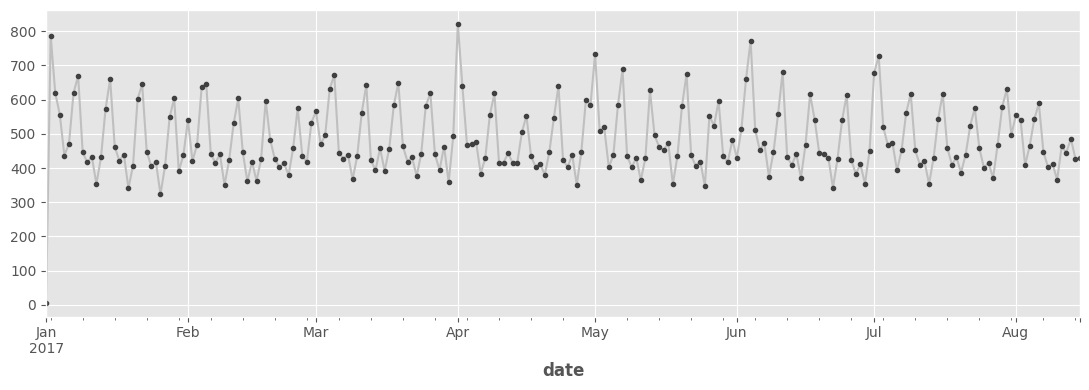

In [30]:
plot_params = dict(
    color='0.75',
    style='.-',
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = average_sales.plot(**plot_params)


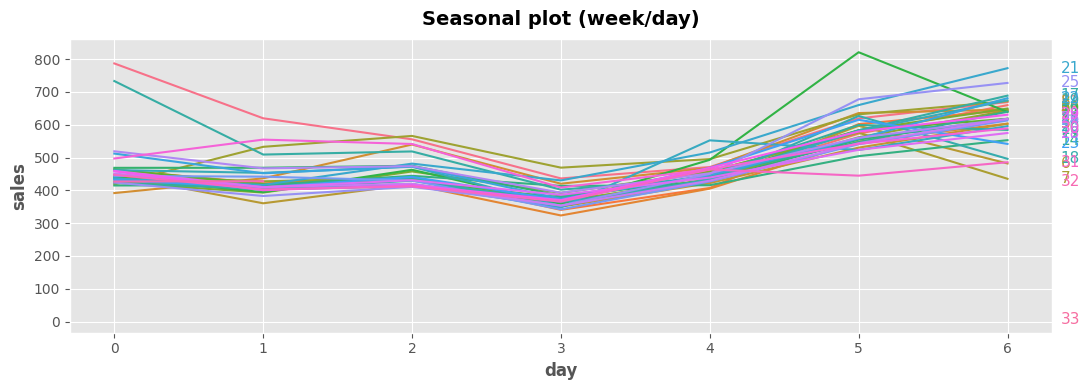

In [53]:
X = average_sales.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek

fig,ax = plt.subplots()
palette = sns.color_palette('husl',n_colors=X['week'].nunique())
ax = sns.lineplot(
    x = 'day',
    y = 'sales',
    data=X,
    hue='week',
    ci=False,
    palette=palette,
    legend=False,
    ax = ax
)

ax.set_title(f'Seasonal plot (week/day)')

for line,name in zip(ax.lines,X['week'].unique()):
    y_ = line.get_ydata()[-1]
    ax.annotate(
        name,
        xy=(1,y_),
        xytext = (6,0),
        color=line.get_color(),
        xycoords = ax.get_yaxis_transform(),
        textcoords='offset points',
        size=11,
        va='center'
    )

fig.show()

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

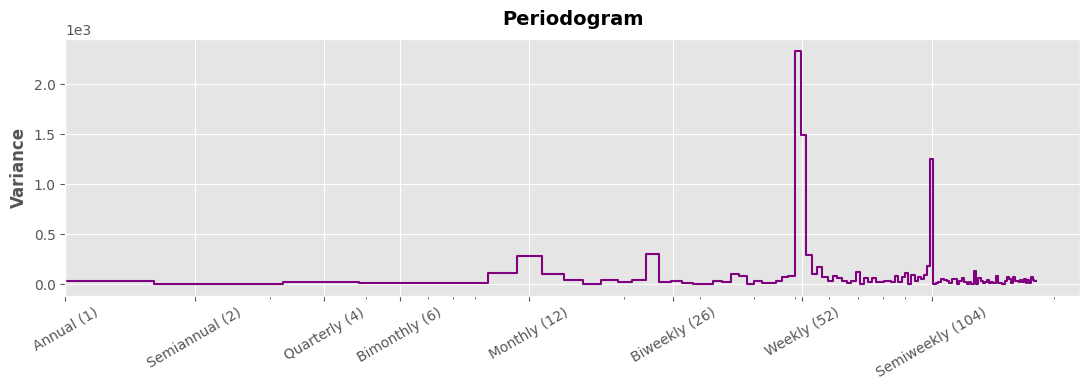

In [55]:
plot_periodogram(average_sales)

In [60]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M',order=4)
dp = DeterministicProcess(
    index = y.index,
    constant=True,
    seasonal=True,
    order=1,
    drop=True,
    additional_terms=[fourier]
)


X = dp.in_sample()
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


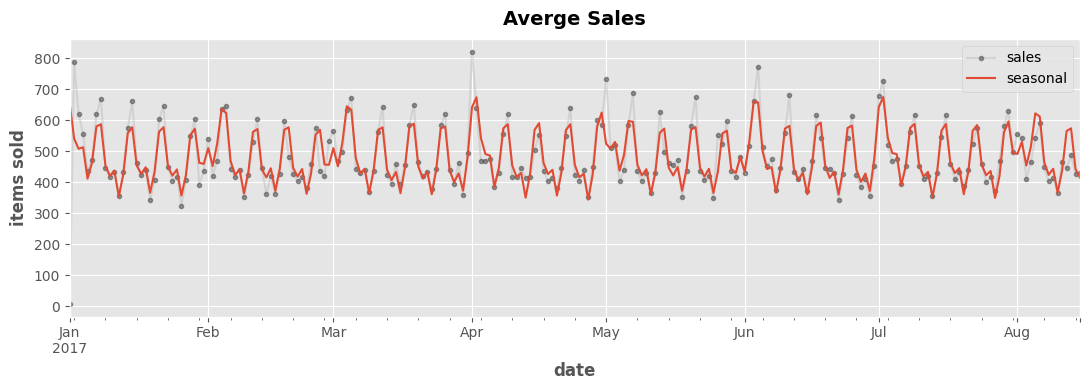

In [69]:
model = LinearRegression().fit(X,y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='fitted'
)

ax = y.plot(**plot_params,alpha=0.5,title='Averge Sales',ylabel='items sold')
ax = y_pred.plot(ax=ax,label='seasonal')
ax.legend()

#### Submission

In [77]:
y = store_sales.unstack(['store_nbr','family']).loc['2017']

fourier = CalendarFourier(freq='M',order=4)

dp = DeterministicProcess(
    index = y.index,
    constant=True,
    seasonal=True,
    order=1,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()
X['New Year'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X,y)

y_pred = pd.DataFrame(model.predict(X),index=X.index, columns=y.columns)
y_pred.head()

sales                                                       
store_nbr              1                                                       
family        AUTOMOTIVE BABY CARE        BEAUTY     BEVERAGES         BOOKS   
date                                                                           
2017-01-01  2.575717e-14       0.0  1.865175e-14 -4.320100e-12  6.661338e-16  \
2017-01-02  4.158065e+00       0.0  3.693728e+00  2.438526e+03  6.524888e-01   
2017-01-03  4.019103e+00       0.0  3.790063e+00  2.556636e+03  9.822520e-01   
2017-01-04  4.086815e+00       0.0  3.626226e+00  2.722500e+03  1.070364e+00   
2017-01-05  3.927327e+00       0.0  3.109574e+00  2.342817e+03  7.886527e-01   

                                                                   
store_nbr                                                          
family      BREAD/BAKERY   CELEBRATION    CLEANING         DAIRY   
date                                                               
2017-01-01  1.136868e-13 -1.465494e-14    0.000000  5.684342e-14  \
2017-01-02  4.339072e+02  1.278250e+01  731.457761  8.363691e+02   
2017-01-03  4.272647e+02  1.496032e+01  862.465320  8.416939e+02   
2017-01-04  5.002280e+02  1.550328e+01  966.010472  9.806785e+02   
2017-01-05  4.429722e+02  1.901495e+01  792.828816  8.212025e+02   

                                                                     
store_nbr                                                            
family              DELI          EGGS  FROZEN FOODS     GROCERY I   
date                                                                 
2017-01-01  5.684342e-14 -4.689582e-13 -2.344791e-13  1.818989e-12  \
2017-01-02  1.590167e+02  1.535787e+02  9.788722e+01  2.853750e+03   
2017-01-03  1.538898e+02  1.456012e+02  9.539749e+01  3.233310e+03   
2017-01-04  1.578011e+02  1.693577e+02  1.358874e+02  3.490937e+03   
2017-01-05  1.313682e+02  1.318191e+02  1.160272e+02  2.938942e+03   

                                                                                
store_nbr                                                                       
family        GROCERY II      HARDWARE HOME AND KITCHEN I HOME AND KITCHEN II   
date                                                                            
2017-01-01  3.463896e-14  1.526557e-14      -7.105427e-15        2.575717e-14  \
2017-01-02  1.658862e+01  1.534440e+00       2.105648e+01        2.442025e+01   
2017-01-03  2.204620e+01  2.151941e+00       2.044201e+01        2.981167e+01   
2017-01-04  2.352376e+01  2.621635e+00       2.811074e+01        3.182598e+01   
2017-01-05  2.360794e+01  2.799962e+00       2.994745e+01        2.930577e+01   

                                                                         
store_nbr                                                                
family     HOME APPLIANCES     HOME CARE    LADIESWEAR LAWN AND GARDEN   
date                                                                     
2017-01-01    2.886580e-15 -6.536993e-13 -6.394885e-14    1.421085e-14  \
2017-01-02    5.313497e-01  2.167357e+02  1.668183e+01    1.541493e+01   
2017-01-03    1.781700e-01  2.312745e+02  1.589683e+01    1.858764e+01   
2017-01-04    2.597945e-01  2.443348e+02  1.970340e+01    2.181224e+01   
2017-01-05    6.953786e-01  1.993894e+02  1.522766e+01    1.404491e+01   

                                                                        
store_nbr                                                               
family          LINGERIE LIQUOR,WINE,BEER     MAGAZINES         MEATS   
date                                                                    
2017-01-01 -9.769963e-15    -1.350031e-13 -1.199041e-14 -4.689582e-13  \
2017-01-02  7.708704e+00     5.886222e+01  4.297621e+00  2.677680e+02   
2017-01-03  1.066113e+01     9.104281e+01  4.806870e+00  3.038468e+02   
2017-01-04  9.122942e+00     1.046426e+02  7.172413e+00  3.116160e+02   
2017-01-05  7.436760e+00     1.033407e+02  6.636881e+00  2.942817e+02   


Text(0.5, 1.0, 'PRODUCE Sales at Store 1')

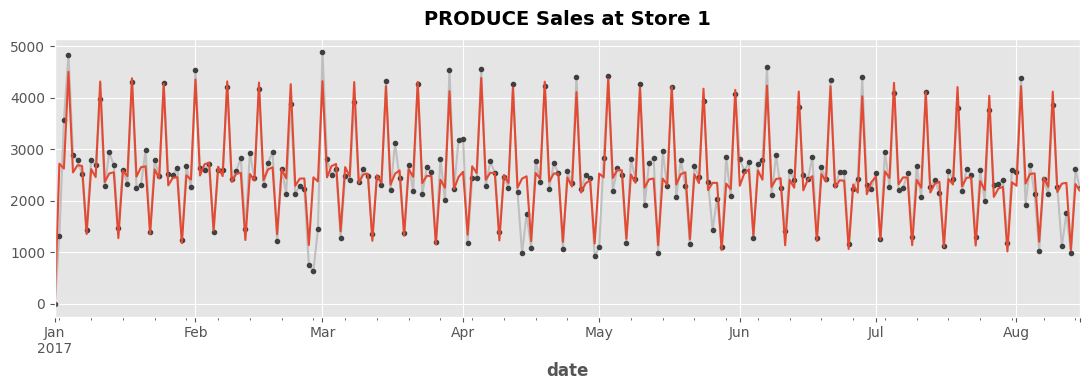

In [81]:
STORE_NBR = '1'
FAMILY = 'PRODUCE'

ax = y.loc(axis=1)['sales',STORE_NBR,FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales',STORE_NBR,FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')

In [87]:
df_test = pd.read_csv(
    data_dir / "test.csv",
    dtype={
        'store_nbr':'category',
        'family':'category',
        'onpromotion':'uint32'
        },
    parse_dates=['date'],
    infer_datetime_format=True
)

df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['New Year'] = (X_test.index.dayofyear == 1)

X_test.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",New Year
date,,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958,False
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958,False
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305,False
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394,False
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139,False


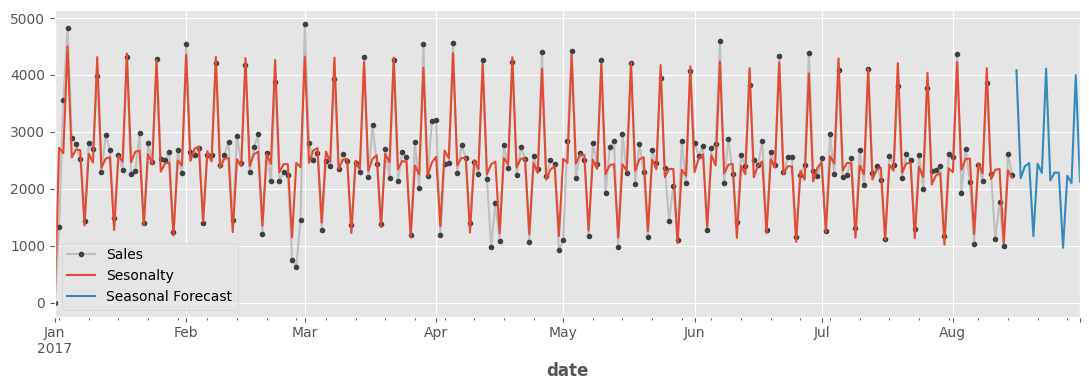

In [113]:
y_submit = pd.DataFrame(model.predict(X_test),index = X_test.index, columns=y.columns)

ax = y.loc(axis=1)['sales',STORE_NBR,FAMILY].plot(**plot_params,label='Sales')
ax = y_pred.loc(axis=1)['sales',STORE_NBR,FAMILY].plot(ax=ax,label='Sesonalty')
ax = y_submit.loc(axis=1)['sales',STORE_NBR,FAMILY].plot(ax=ax,label='Seasonal Forecast')

ax.legend()

In [114]:
y_submit = y_submit.stack(['store_nbr','family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id','sales'])

y_submit.to_csv('submission.csv')

In [128]:
submission = pd.read_csv(
    data_dir / 'sample_submission.csv',
)

submission =  submission.merge(y_submit,how='left',on='id')
submission = submission.drop(columns=['sales_x']).rename({'sales_y':'sales'})
submission.head()

,id,sales_y
0,3000888,4.274030
1,3000889,0.000000
2,3000890,3.495530
3,3000891,2414.541711
4,3000892,0.438314


In [130]:
submission.to_csv('submission.csv',index=False)